In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

# Microphone Locations

The positions of the microphones in the room are calculated based on certain parameters:

- `mic_height`: The height of the microphone from the ground.
- `feet`: Conversion factor from feet to inches.
- `y_tile`: The y-coordinate of a tile in the room.
- `x_tile`: The x-coordinate of a tile in the room.

The coordinates of the microphones are determined using these parameters:

- `mic_1`: Position of microphone 1.
- `mic_4`: Position of microphone 4.
- `mic_6`: Position of microphone 6.
- `mic_9`: Position of microphone 9.

These positions are calculated using a combination of the tile coordinates and mic_height, and then converted to millimeters.

The positions of all microphones are stored in the `mic_xyzs` array for further use.


In [2]:
# Microphone Locations
mic_height = 50.3125
feet = 12
y_tile = 23.5
x_tile = 11 +7/8

camera_origin_location = np.array([-6*x_tile-5.75, -y_tile, 45+13/16])*25.4

mic_1 = np.array([-11*x_tile - 1, -5*y_tile - 6-3/8, mic_height]) * 25.4 
mic_4= np.array([-11*x_tile + 1.25 + 1/16, 2.5*y_tile+3.75, mic_height]) * 25.4
mic_6 = np.array([5+3/8, 2+1/8, mic_height]) * 25.4
mic_9 = np.array([-3, -6*y_tile - 0.5, mic_height]) * 25.4

mic_xyzs = np.stack((mic_1,mic_4, mic_6, mic_9),axis=0)

The speaker positions in the room are calculated based on the coordinates of the speaker's corners:

- `SPEAKER_BOTTOM_RIGHT_Y`: Average y-coordinate of the bottom right corner of the speaker.
- `SPEAKER_BOTTOM_RIGHT_X`: Average x-coordinate of the bottom right corner of the speaker.
- `SPEAKER_BOTTOM_LEFT_Y`: Average y-coordinate of the bottom left corner of the speaker.
- `SPEAKER_BOTTOM_LEFT_X`: Average x-coordinate of the bottom left corner of the speaker.

Using these coordinates, the positions of the speaker corners in 3D space are determined:

- `speaker_xyz_bottom_right`: Position of the bottom right corner of the speaker.
- `speaker_xyz_bottom_left`: Position of the bottom left corner of the speaker.
- `speaker_xyz_top_right`: Position of the top right corner of the speaker.
- `speaker_xyz_top_left`: Position of the top left corner of the speaker.

Finally, the centroid of these four corners is computed to find the average position of the speaker in the room, represented by `speaker_xyz`.


In [3]:
SPEAKER_BOTTOM_RIGHT_Y = (1200.15 + 1196.975 + 1206.5)/ 3
SPEAKER_BOTTOM_RIGHT_X = (88.9 + 107.95 + 101.6) / 3
SPEAKER_BOTTOM_LEFT_Y = (1327.15 + 1311.55712764 + 1317.625) / 3
SPEAKER_BOTTOM_LEFT_X = - 76.98583188

speaker_xyz_bottom_right = np.array([SPEAKER_BOTTOM_RIGHT_X, SPEAKER_BOTTOM_RIGHT_Y, 44.5*25.4])
speaker_xyz_bottom_left = np.array([SPEAKER_BOTTOM_LEFT_X, SPEAKER_BOTTOM_LEFT_Y, 44.5*25.4])
speaker_xyz_top_right = np.array([SPEAKER_BOTTOM_RIGHT_X, SPEAKER_BOTTOM_RIGHT_Y, (44.5+17)*25.4])
speaker_xyz_top_left = np.array([SPEAKER_BOTTOM_LEFT_X, SPEAKER_BOTTOM_LEFT_Y, (44.5+17)*25.4])
speaker_xyz = (speaker_xyz_bottom_right+speaker_xyz_bottom_left+speaker_xyz_top_right+speaker_xyz_top_left)/4

The boundaries of the room are defined by the following parameters:

- `walls`: Currently set to `None`, indicating that the walls of the room are not explicitly defined.
- `x_min`: The minimum x-coordinate of the room.
- `x_max`: The maximum x-coordinate of the room.
- `y_min`: The minimum y-coordinate of the room.
- `y_max`: The maximum y-coordinate of the room.

These parameters specify the boundaries within which all objects, such as microphones, speakers, and humans, are located. In this case, the room is assumed to have a rectangular shape, with coordinates ranging from `(x_min, y_min)` to `(x_max, y_max)`.


In [5]:
walls = None
x_min = - 4000
x_max = 500
y_min = -4000
y_max = 2000

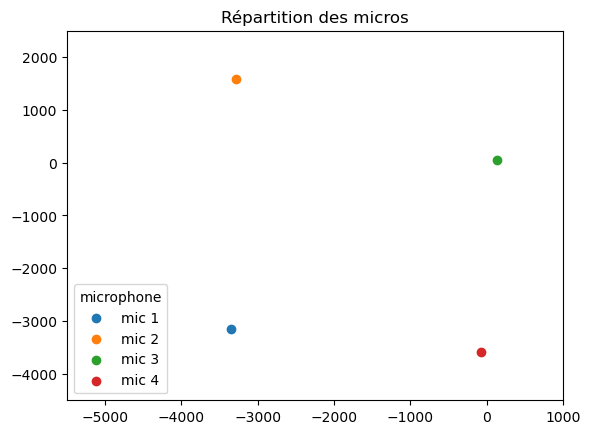

In [6]:
for idx, mic in enumerate(mic_xyzs):
    plt.scatter(mic[0], mic[1], label=f'mic {idx+1}')

plt.title("Répartition des micros")
plt.xlim([-5500, 1000])
plt.ylim([-4500, 2500])
plt.legend(loc="lower left", title="microphone")

### Explanation:
This code loads and combines Room Impulse Response (RIR) data and localization data (centroid positions) for two different humans (Human1 and Human2) in the same living room environment.

### Room Impulse Response (RIR):
The RIR represents the acoustic properties of a room or environment. It captures how sound is reflected, absorbed, and diffracted by various surfaces and objects within the room. The RIR is obtained by recording the response of the room to an impulse or short burst of sound.


### Root Mean Square (RMS):
RMS is a statistical measure that represents the effective value or "energy" of a varying quantity, such as an audio signal. It is often used to describe the perceived loudness of an audio signal.

In the code:
1. The RIRs for Human1 and Human2 are loaded from separate files (deconvolved_trim.npy) using np.load().

2. The RIRs are combined into a single array (rirs) using np.append() along the first axis (axis=0).

3. Similarly, the localization data (centroid positions) for Human1 and Human2 are loaded and combined into a single array (localisations).

4. The shapes of the rirs and localisations arrays are printed using print(rirs.shape) and print(localisations.shape).

5. The shape of the rirs array is unpacked into variables N_datapoints, N_mics, and N_samples, representing the number of individual RIR measurements, the number of microphones used, and the number of samples (or length) of each RIR signal, respectively.

6. The number of samples (N_samples) in each RIR signal is printed using print(N_samples).

This code processes and combines RIR and localization data for multiple humans in the same environment, allowing for further analysis or model training using this combined data.

In [13]:
rirs_1 = np.load('data/LivingRoom_preprocessed_hack/Human1/deconvoled_trim.npy')
rirs_2 = np.load('data/LivingRoom_preprocessed_hack/Human2/deconvoled_trim.npy')
rirs = np.append(rirs_1, rirs_2, axis=0)

In [14]:
localisations_1 = np.load('../Acoustic-IA-Data-Hack-2024/data/LivingRoom_preprocessed_hack/Human1/centroid.npy')
localisations_2 = np.load('../Acoustic-IA-Data-Hack-2024/data/LivingRoom_preprocessed_hack/Human2/centroid.npy')
localisations = np.append(localisations_1, localisations_2, axis=0)

In [15]:
print(rirs.shape)
print(localisations.shape)
N_datapoints, N_mics, N_samples = rirs.shape
print(N_samples)

(1104, 4, 667200)
(1104, 2)
667200


In [9]:
rms = np.sqrt(np.square(rirs).mean(axis=2))

In [10]:
print(rms)

[[0.00052505 0.00050232 0.00070836 0.00042991]
 [0.00052084 0.00049965 0.00070709 0.0004291 ]
 [0.00052198 0.00049891 0.00070534 0.00042922]
 ...
 [0.00051298 0.00049805 0.00068633 0.00042337]
 [0.00051482 0.00048913 0.00068826 0.00042545]
 [0.00051369 0.00049861 0.00069317 0.00042304]]


In [11]:
def distance(actual, expected):
    diff_x = actual[:, 0] - expected[:, 0]
    diff_y = actual[:, 1] - expected[:, 1]
    return np.sqrt(np.square(diff_x) + np.square(diff_y))

def mean_distance(actual, expected):
    return distance(actual, expected.to_numpy()).mean()

In [12]:

X = pd.DataFrame(rms)
y = pd.DataFrame(localisations)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

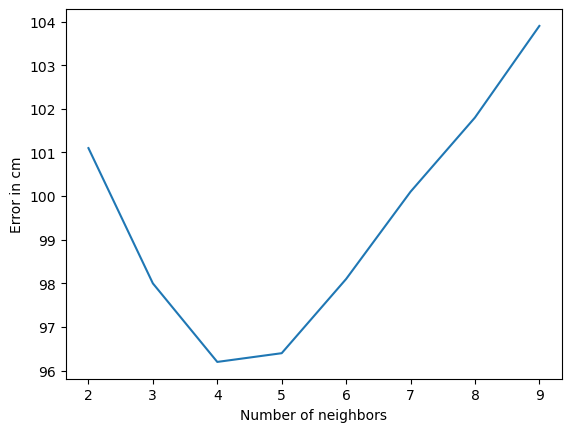

In [13]:

nb_neighbors = []
mean_distance_list = []
for i in range(2, 10):
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(X_train, y_train)
    nb_neighbors.append(i)
    mean_distance_list.append(round(mean_distance(knn.predict(X_test), y_test), 0) / 10)
plt.xlabel("Number of neighbors")
plt.ylabel("Error in cm")
plt.plot(nb_neighbors, mean_distance_list)
plt.show()

The graph shows the relationship between the number of neighbors (k) used in the K-Nearest Neighbors (KNN) regression algorithm and the resulting error (measured as the mean distance between the predicted and true values, divided by 10).

The graph has a U-shaped curve, which is typical of the KNN algorithm. When the number of neighbors is small (2 or 3), the error is relatively high because the model may not capture the true pattern in the data. As the number of neighbors increases from 2 to around 4, the error decreases, indicating that the model is becoming more accurate.

However, as the number of neighbors continues to increase beyond 4, the error starts to increase again. This is likely due to overfitting, where the model becomes too heavily influenced by the noise in the training data, leading to poor generalization to new, unseen data.

Based on the graph, the best number of neighbors is 4, as it corresponds to the lowest point on the U-shaped curve, indicating the minimum error achieved by the KNN regression model on this particular dataset.

In [14]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
print(f"score: {knn.score(X_test, y_test)}")
print(f"distance moyenne: {round(mean_distance(knn.predict(X_test), y_test), 0) / 10} cm")

score: 0.46919474541537326
distance moyenne: 96.4 cm


In [15]:

reg = LinearRegression()
reg.fit(X_train, y_train)
print(f"score: {reg.score(X_test, y_test)}")
print(f"distance moyenne: {round(mean_distance(reg.predict(X_test), y_test), 0) / 10} cm")

score: 0.13984136122161933
distance moyenne: 149.5 cm


### Use Short Term Fourier Transform to convert RIR into spectrogram

In [19]:
sound_data = rirs[:, :, ::3].mean(axis = 1)[:, :30950]

fs = 16000  # Sampling frequency (samples per second) = 16kHz

# Generate spectrogram of one sample
frequencies, times, Zxx = signal.stft(sound_data[0], fs=fs)

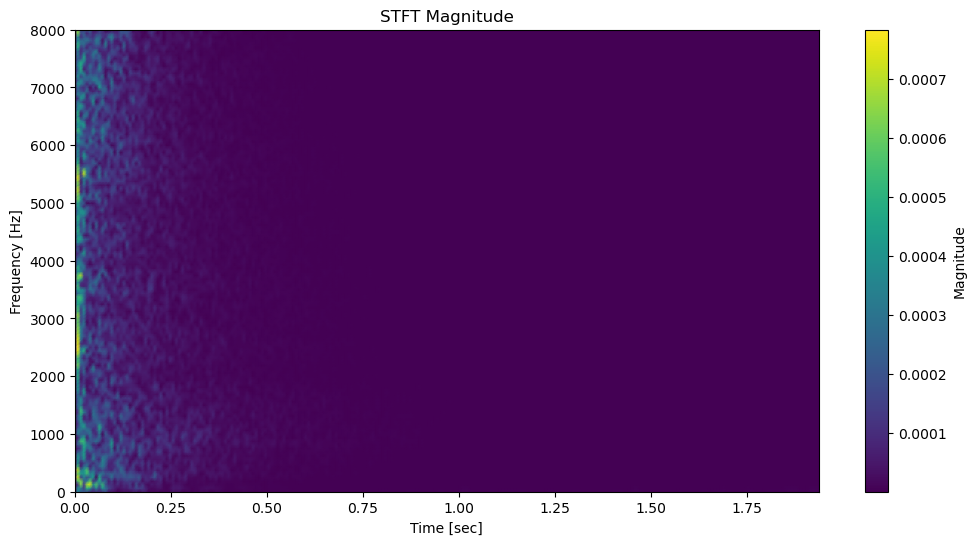

In [20]:
plt.figure(figsize=(12, 6))
plt.pcolormesh(times, frequencies, np.abs(Zxx), shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Magnitude')
plt.show()